# Forward model

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob as glob
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns

import corner
import json
import pathlib
import pickle
import utils
import warnings

from astropy import constants as const
from astropy import units as uni
from astropy.io import ascii, fits
from astropy.time import Time
from mpl_toolkits.axes_grid1 import ImageGrid

# Default figure dimensions
FIG_WIDE = (11, 5)
FIG_LARGE = (8, 11)

# Figure style
sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
params = utils.plot_params()
plt.rcParams.update(params)

## [Dowload data](https://www.dropbox.com/sh/doodr03yahhlj4o/AADRR2qYVBhJepKxcp27dH_Da?dl=1)

Unzip this into a folder named `data` in the same level as this notebook

## Load

In [3]:
base_dir = "data/tspec_forward_model"

# Transmission spectrum data
wav, tspec_combined, tspec_combined_unc = np.genfromtxt(
    f"{base_dir}/tspec_c.txt", unpack=True
)
mean_wlc_depth, mean_wlc_depth_unc = np.genfromtxt(
    f"{base_dir}/mean_wlc_depth_c.txt", unpack=True
)

# Forward model data
offsets = (0.0, 0.00034496, 0.00034496)
forward_models = {
    "best_fit": "trans-iso-generic_2500_20_+1.0_0.35_0001_0.00_model_scaled",
    "cloud":    "trans-iso-generic_2500_20_+1.0_0.35_0001_1.00_model_scaled",
    "haze":     "trans-iso-generic_2500_20_+1.0_0.35_1100_0.00_model_scaled",
}
data_dict = {
    model_type: {
        "params_string": model_file_name,
        "wav": np.genfromtxt(f"{base_dir}/{model_file_name}.txt", usecols=0),
        "depth": np.genfromtxt(f"{base_dir}/{model_file_name}.txt", usecols=1) + offset,
    }
    for (model_type, model_file_name), offset in zip(forward_models.items(), offsets)
}

In [4]:
def parse_params(s):
    tokens = s.split('_')
    T = tokens[1]
    g = tokens[2]
    Z = tokens[3]
    C_O = tokens[4]
    Haze = tokens[5]
    Cloud = tokens[6]
    return f"T={T}, g={g}, Z={Z}, C/O={C_O}, Haze={Haze}, Cloud={Cloud}"

## Plot

Text(0, 0.5, 'Transit Depth (ppm)')

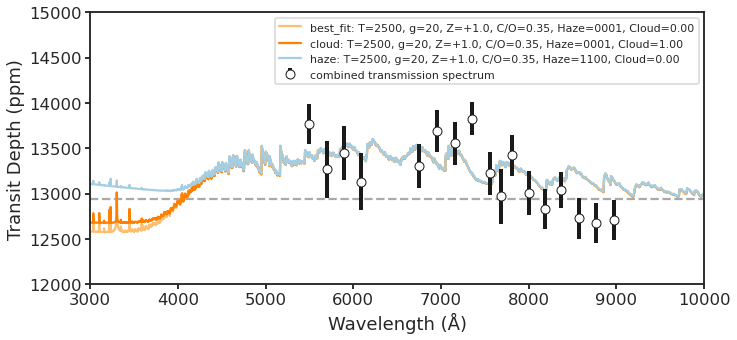

In [5]:
fig, ax = plt.subplots(figsize=FIG_WIDE)

# Mean WLC depth
ax.axhline(mean_wlc_depth, color="darkgrey", zorder=0, ls="--")

# Forward model
for (model_type, model_data) in data_dict.items():
    ax.plot(
        model_data["wav"] * 1e4,
        model_data["depth"] * 1e6,
        label = f"{model_type}: " + parse_params(model_data["params_string"]),
    )

# IMACS data
ax.errorbar(
    wav,
    tspec_combined,
    yerr=tspec_combined_unc,
    c="w",
    mec="k",
    fmt="o",
    zorder=10,
    label="combined transmission spectrum",
    ecolor="k",
    lw=4,
)

# Save
ax.legend(fontsize=11)
ax.set_xlim(3_000, 10_000)
ax.set_ylim(12_000, 15_000)
ax.set_xlabel("Wavelength (Å)")
ax.set_ylabel(r"Transit Depth (ppm)")
#utils.savefig(f"../paper/figures/tspec_forward_model/tspec_forward_model.pdf")